# Exploratory analysis on volume correlations

In [1]:
from itertools import combinations, combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from matplotlib.patches import RegularPolygon
from matplotlib.transforms import Bbox
from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume_corr,
)
from pkg.inference import run_ksample, run_pairwise
from pkg.plot import plot_heatmaps, plot_pairwise
from pkg.utils import binarize, squareize, threshold2
from scipy.stats import kruskal, mannwhitneyu, wilcoxon
from seaborn.utils import relative_luminance
from statsmodels.stats.multitest import multipletests

matplotlib.rcParams["font.family"] = "monospace"

## Plot the data

In [13]:
# Load the data

volume_correlations, labels = load_volume_corr()

meta = load_vertex_df()

In [14]:
volume_correlations = binarize(volume_correlations)

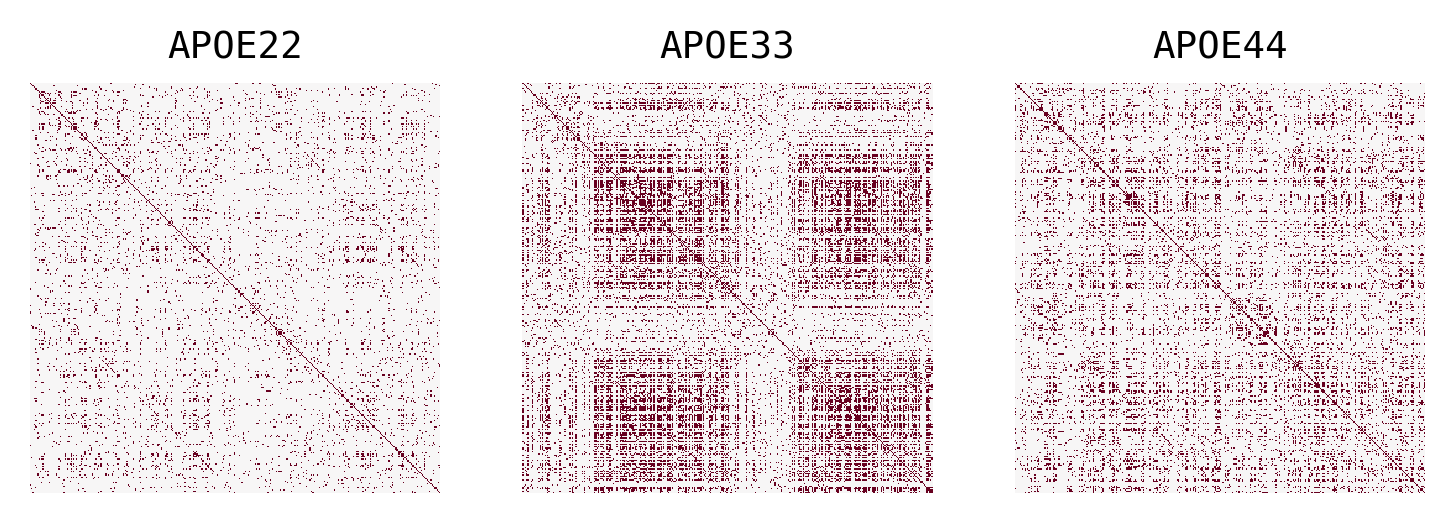

In [15]:
## Plot to make sure nothing is wrong
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=300)

for idx, label in enumerate(labels):
    sns.heatmap(
        volume_correlations[idx],
        ax=ax[idx],
        vmin=-1,
        vmax=1,
        cbar=False,
        cmap="RdBu_r",
        xticklabels=False,
        yticklabels=False,
        center=0,
        square=True,
    )
    ax[idx].set(title=label)

## Vectorize matrix and compute kruskal-wallis

We use KW test for speed since computing large distance distance matrices can be difficult to compute.

In [16]:
# use kruskal-wallis for speed

idx = np.triu_indices_from(volume_correlations[0], k=1)

kruskal(*[c[idx] for c in volume_correlations])

KruskalResult(statistic=4874.055352320534, pvalue=0.0)

## Try apriori community

In [17]:
vertex_hemispheres = meta.Hemisphere.values
vertex_structures = meta.Level_1.values
vertex_hemisphere_structures = (meta.Hemisphere + "-" + meta.Level_1).values
vertex_hemisphere_substructures = (
    meta.Hemisphere + "-" + meta.Level_1 + "-" + meta.Level_2
).values

volume_ksample = [
    run_ksample(volume_correlations, labels, idx, test="kruskal", absolute=False)
    for idx, labels in enumerate(
        [
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ]
    )
]

volume_ksample = pd.concat(volume_ksample, ignore_index=True)

volume_ksample.to_csv(
    "../results/outputs/volume_correlation_3sample_apriori_threshold.csv", index=False
)

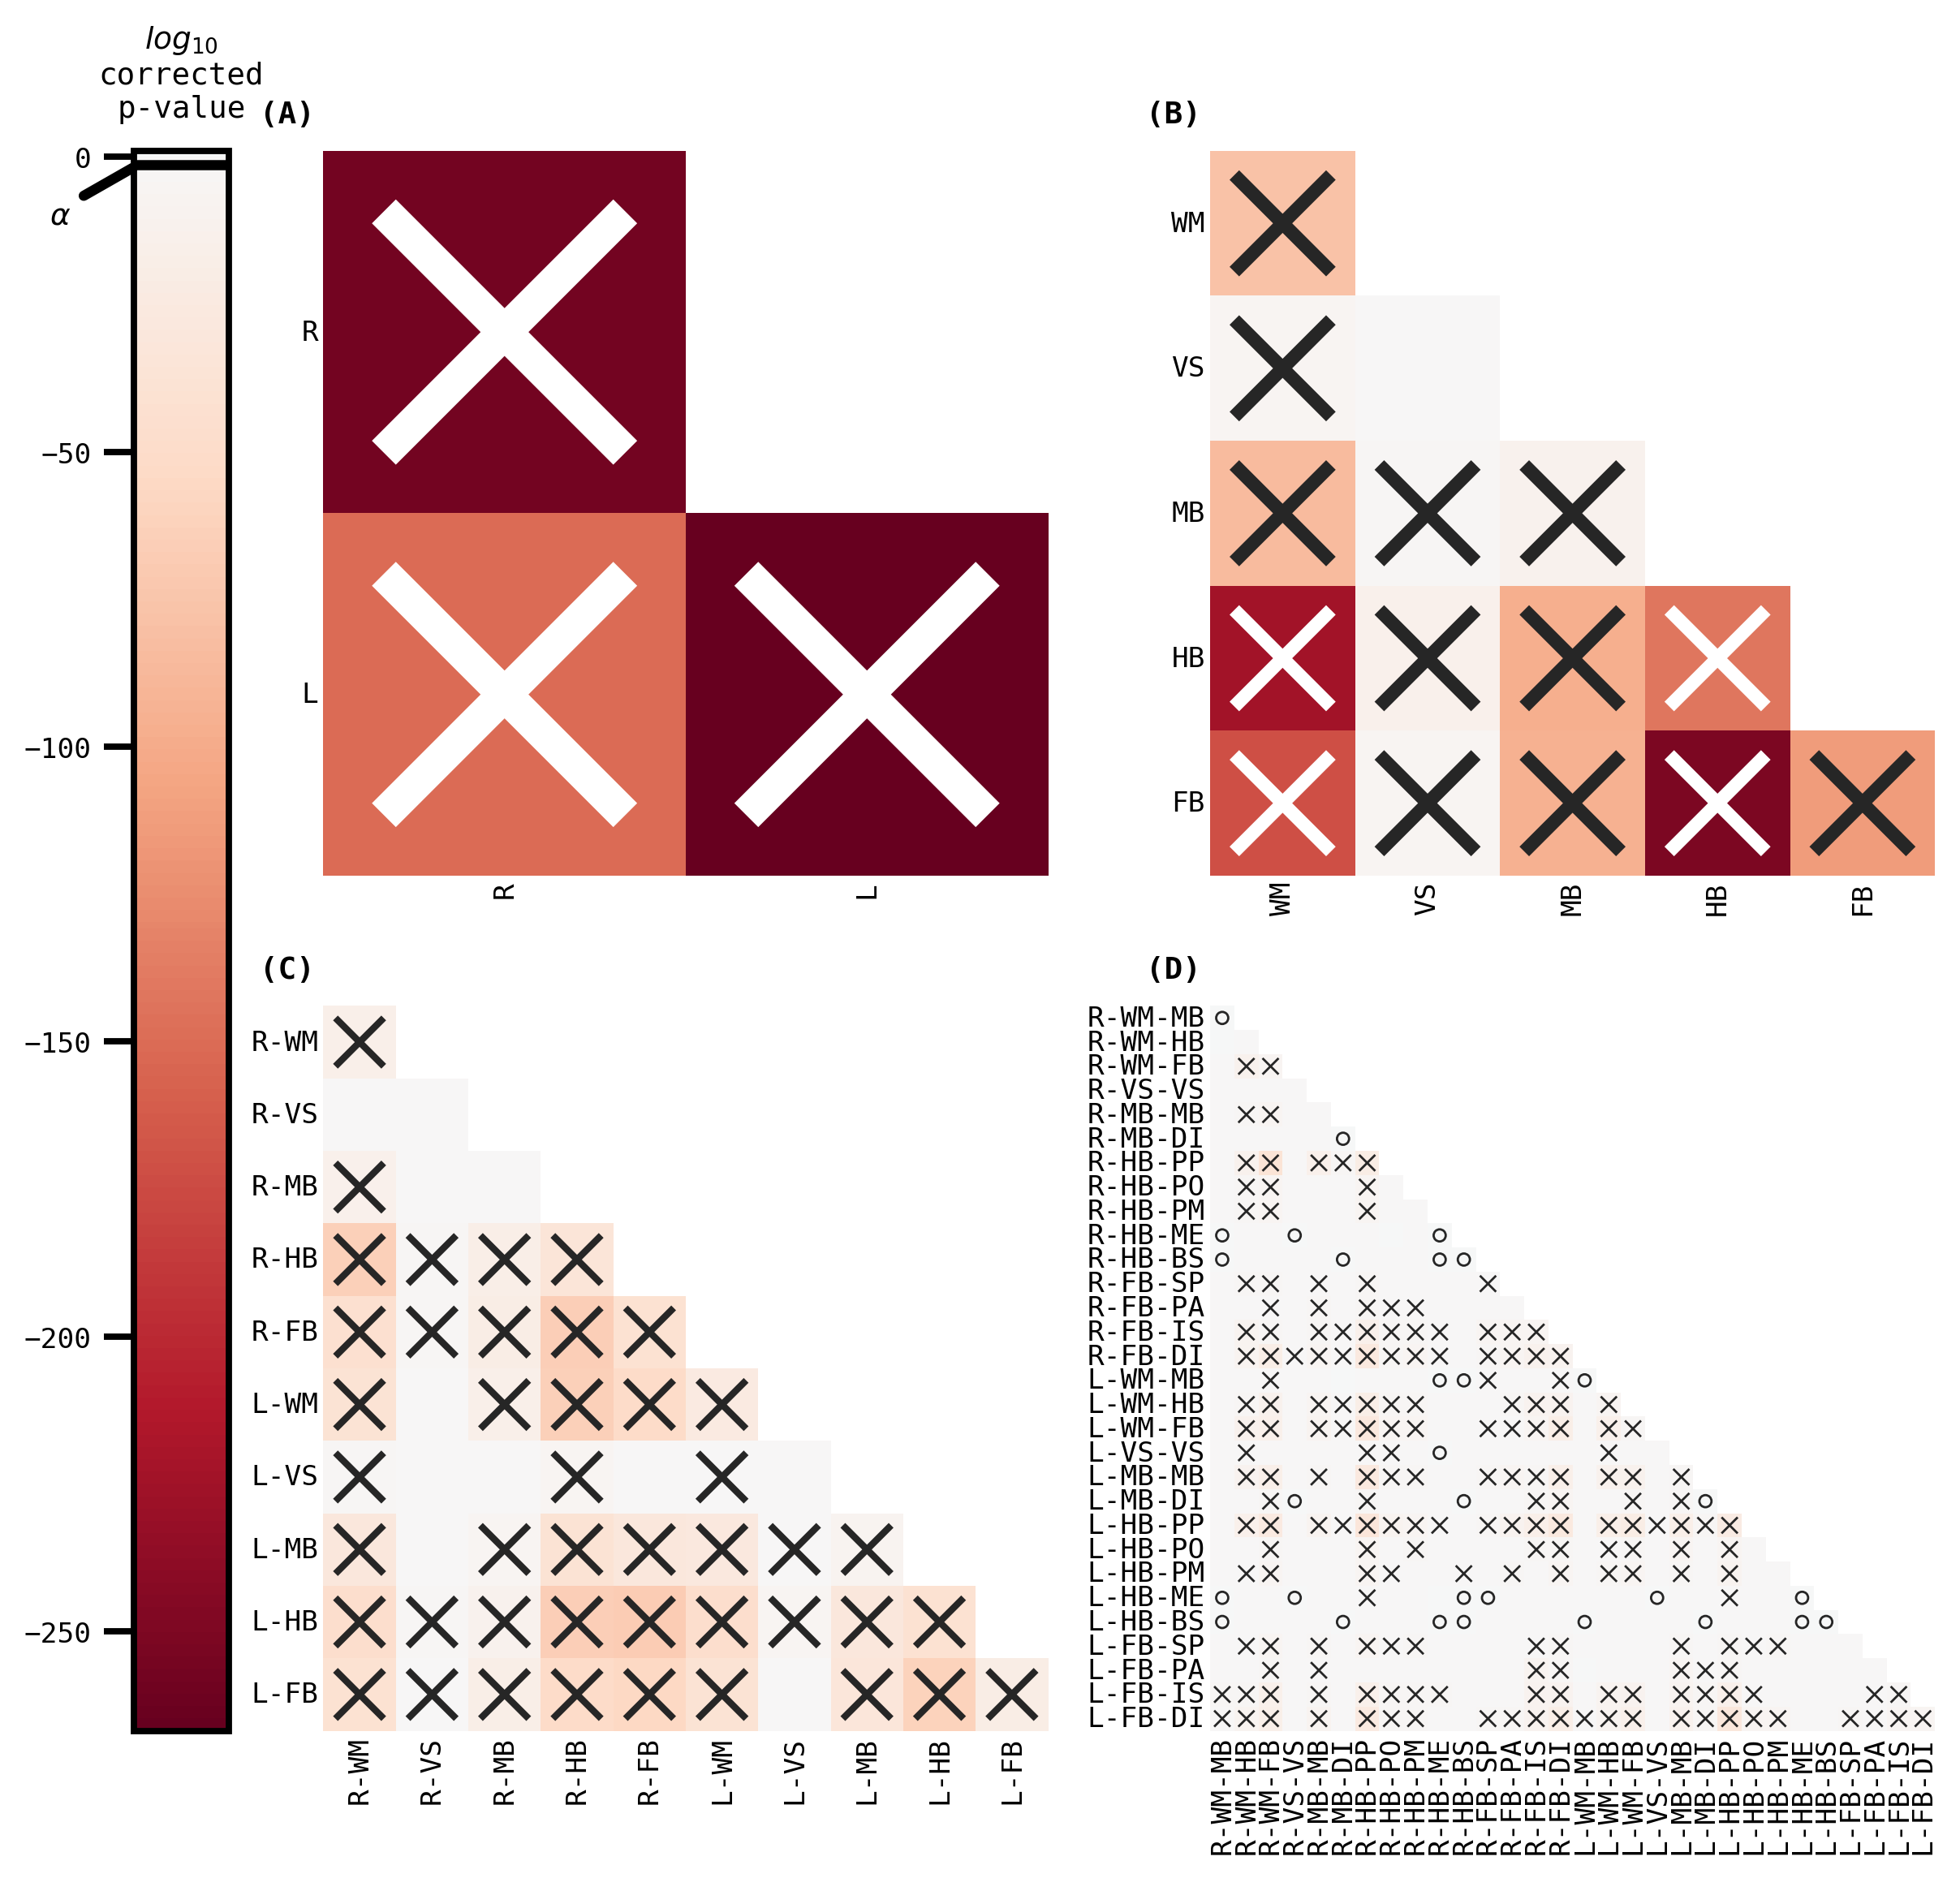

In [18]:
sns.set_context("talk", font_scale=0.5)
fig, _ = plot_heatmaps(volume_ksample, True)

fig.savefig("./figures/apriori_ksample_volume_threshold.pdf")

## Do FA

In [ ]:
fa_correlations, labels = load_fa_corr()

fa_ksample = [
    run_ksample(fa_correlations, labels, idx, test="manova", absolute=True)
    for idx, labels in enumerate(
        [
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ]
    )
]

fa_ksample = pd.concat(fa_ksample, ignore_index=True)
fa_ksample.to_csv("../results/outputs/fa_correlation_3sample_apriori.csv", index=False)

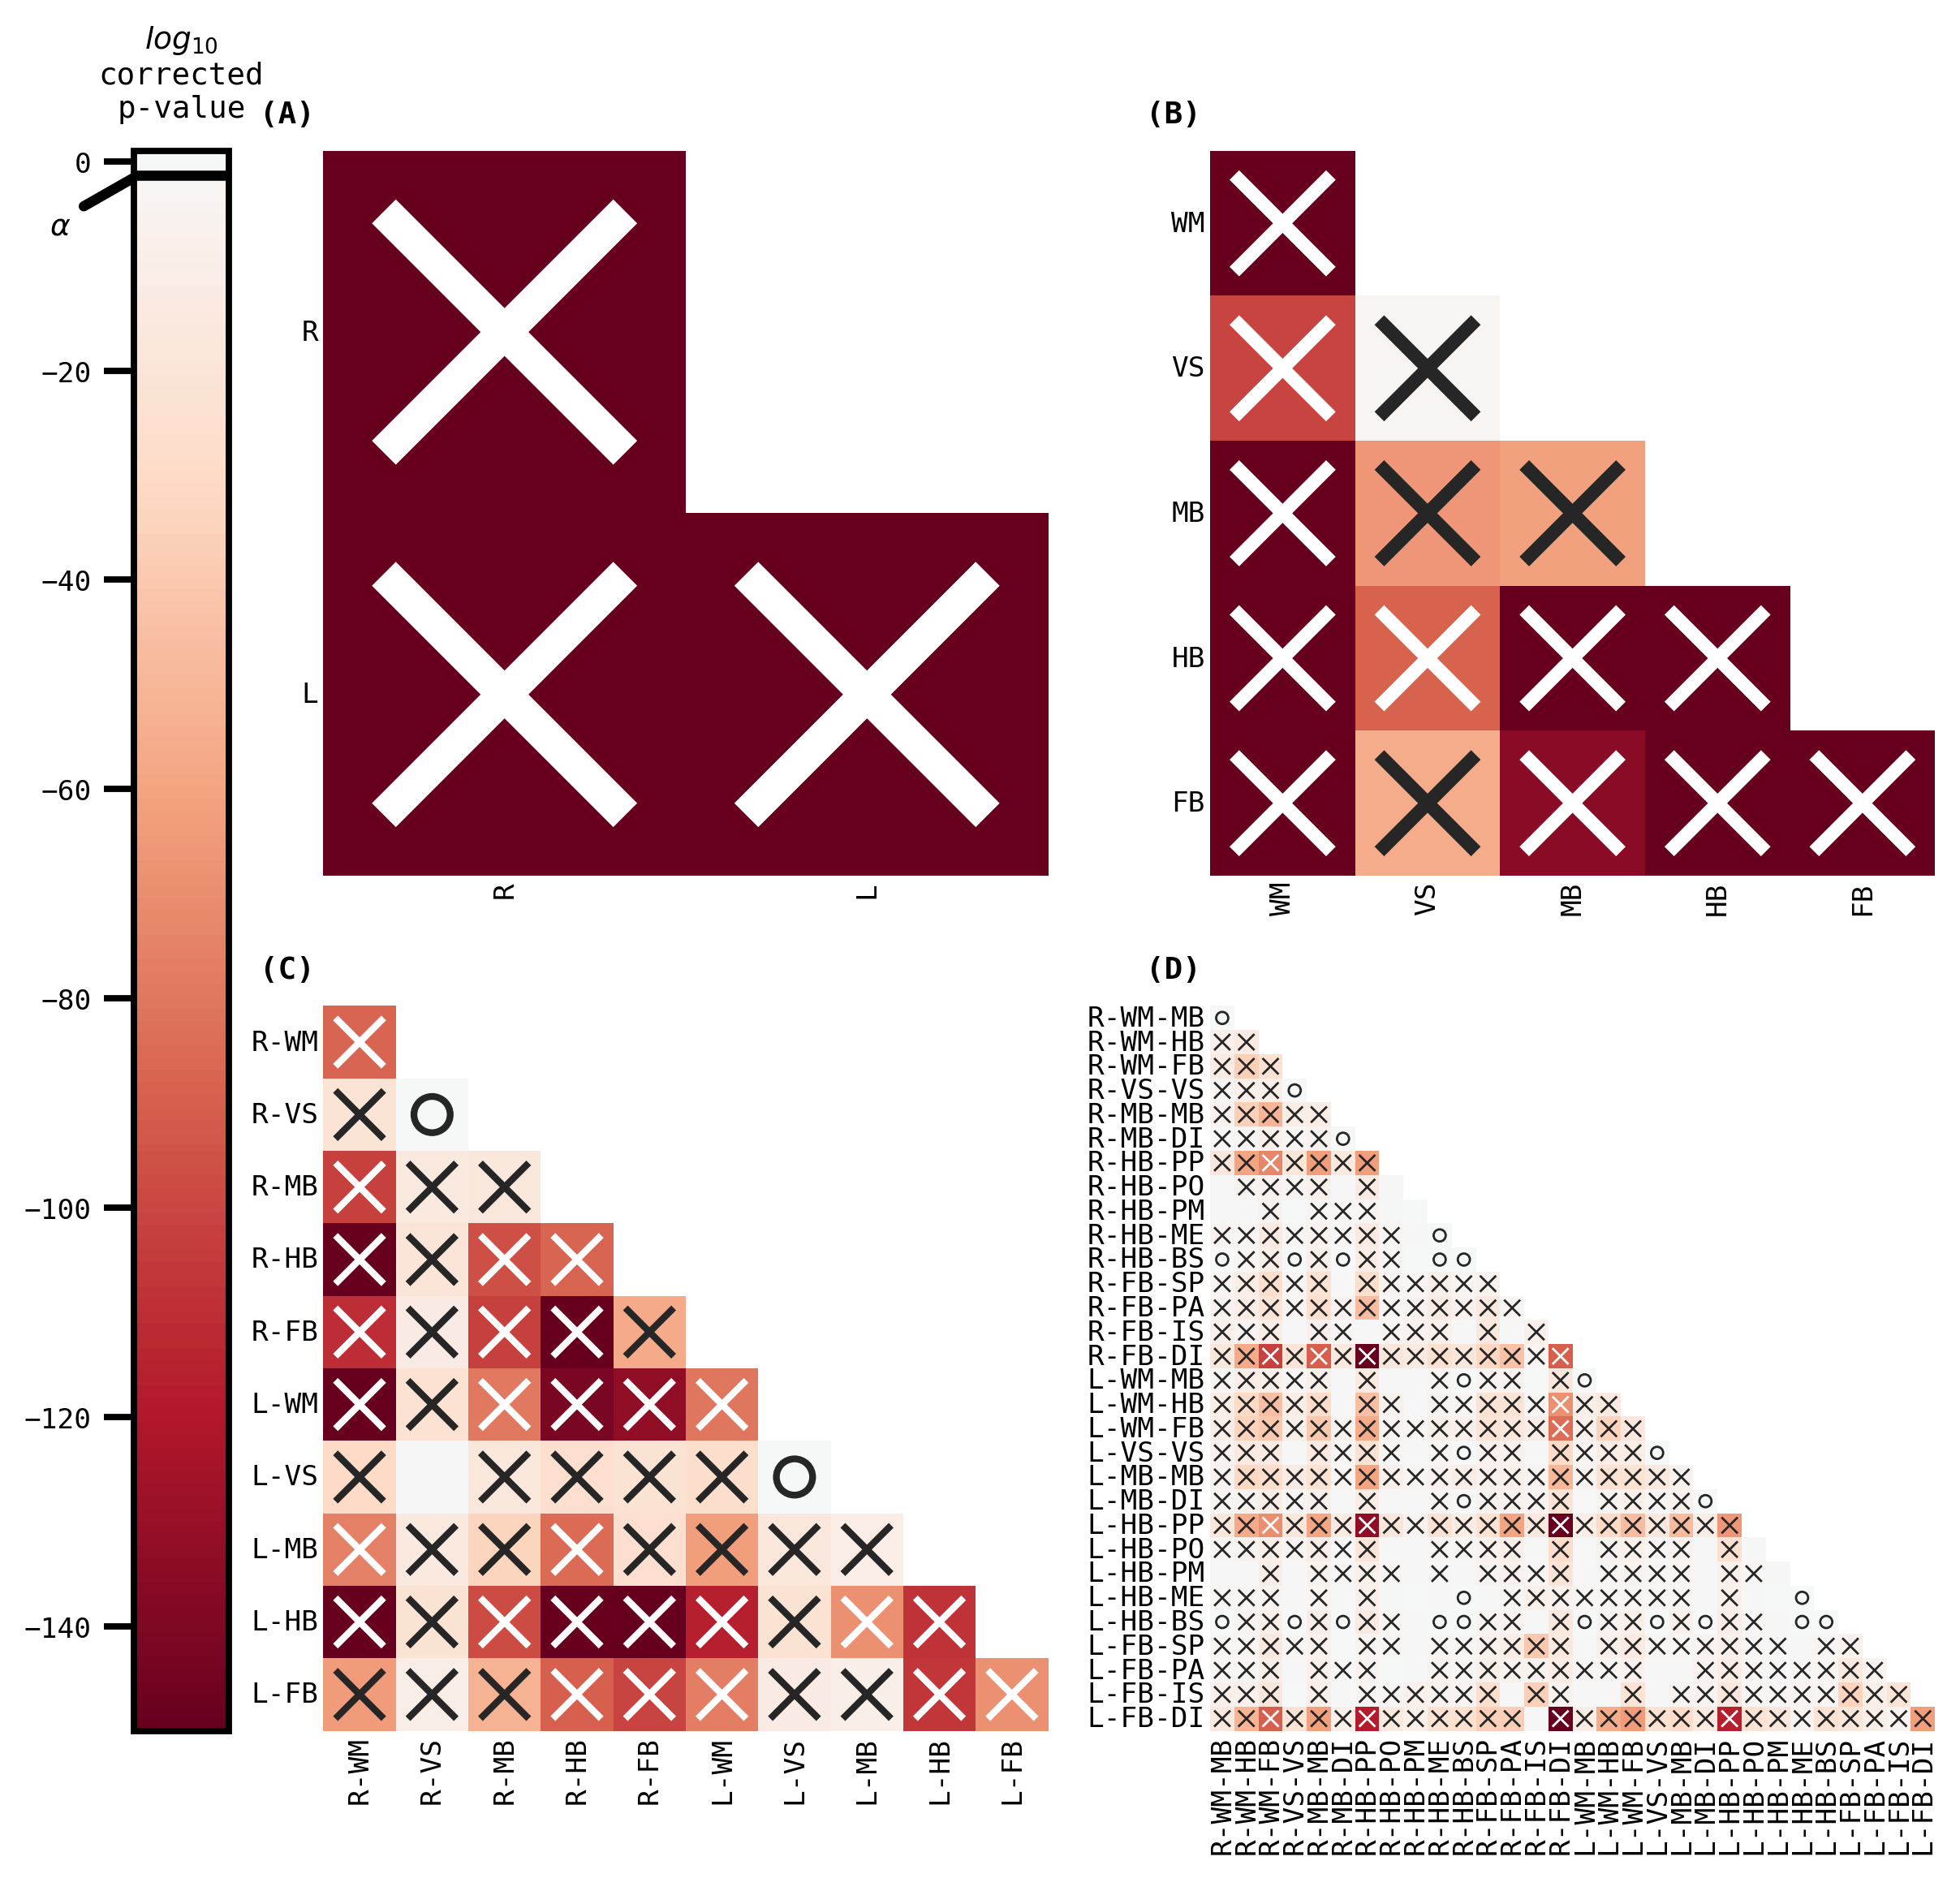

In [9]:
fig, _ = plot_heatmaps(fa_ksample, True)

fig.savefig("./figures/apriori_ksample_fa_binarized.pdf")

## Statistical Experiment

For a given pair of sub-regions (Left/Right Forebrain, Midbrain, Hindbrain, White Matter Tracts) $k$ and $l$, do the edges incident nodes between a pair of sub-regions have the same, or a different, distribution? Formally, consider the following model. Let $a_{ij}^{(y)}$ be the edge-weight for edge $i, j$, and let $z_i \in [K]$ be the node label for node $i$, where $y \in \{APOE22, APOE33, APOE44\}$ is the class of the network:

\begin{align*}
    a_{ij}^{(y)} | z_i = k, z_j = l \overset{ind.}{\sim} F^{(y)}_{k,l}
\end{align*}

where $F^{(y)}_{k,l}$ is the distribution function for the community of edges $k$ and $l$ in a network of class $y$. For a given tuple of node communities $(k,l)$ and $(k',l')$, the hypothesis of interest is:
\begin{align*}
    H_{0, k, l}^{(y, y')} : F^{(y)}_{k,l} = F^{(y')}_{k,l} \text{ against }H^{(y)}_{A, k,l}: F^{(y)}_{k,l} = F^{(y')}_{k,l}
\end{align*}

The interpretation of a $p$-value less than the cutoff threshold $\alpha = 0.05$ (after Bonferroni-Holm adjustment) for a given pair of classes $(y, y')$ at a given community pair $(k, l)$ is that the data does not support the null hypothesis, that the community pairing shares an equal distribution between the indicated pair of classes. A sufficient test for this context (univariate data, assumed to be independent, paired) is the Wilcoxon Signed-Rank Test, which can be performed using `scipy`.

The outcomes (p-values) can be visualized as pairs of heatmaps between a given pair of classes. Further, since the edges are undirected, we can ignore the off-diagonals of the matrix. These outcomes are then ranked, where a large rank indicates the smaller p-values.

In [19]:
volume_pairwise = run_pairwise(
    volume_correlations,
    GENOTYPES,
    vertex_hemisphere_substructures,
    absolute=False,
    test="wilcoxon",
)

/home/j1c/.cache/pypoetry/virtualenvs/badea-mouse-hpiA0Xqr-py3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/j1c/.cache/pypoetry/virtualenvs/badea-mouse-hpiA0Xqr-py3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


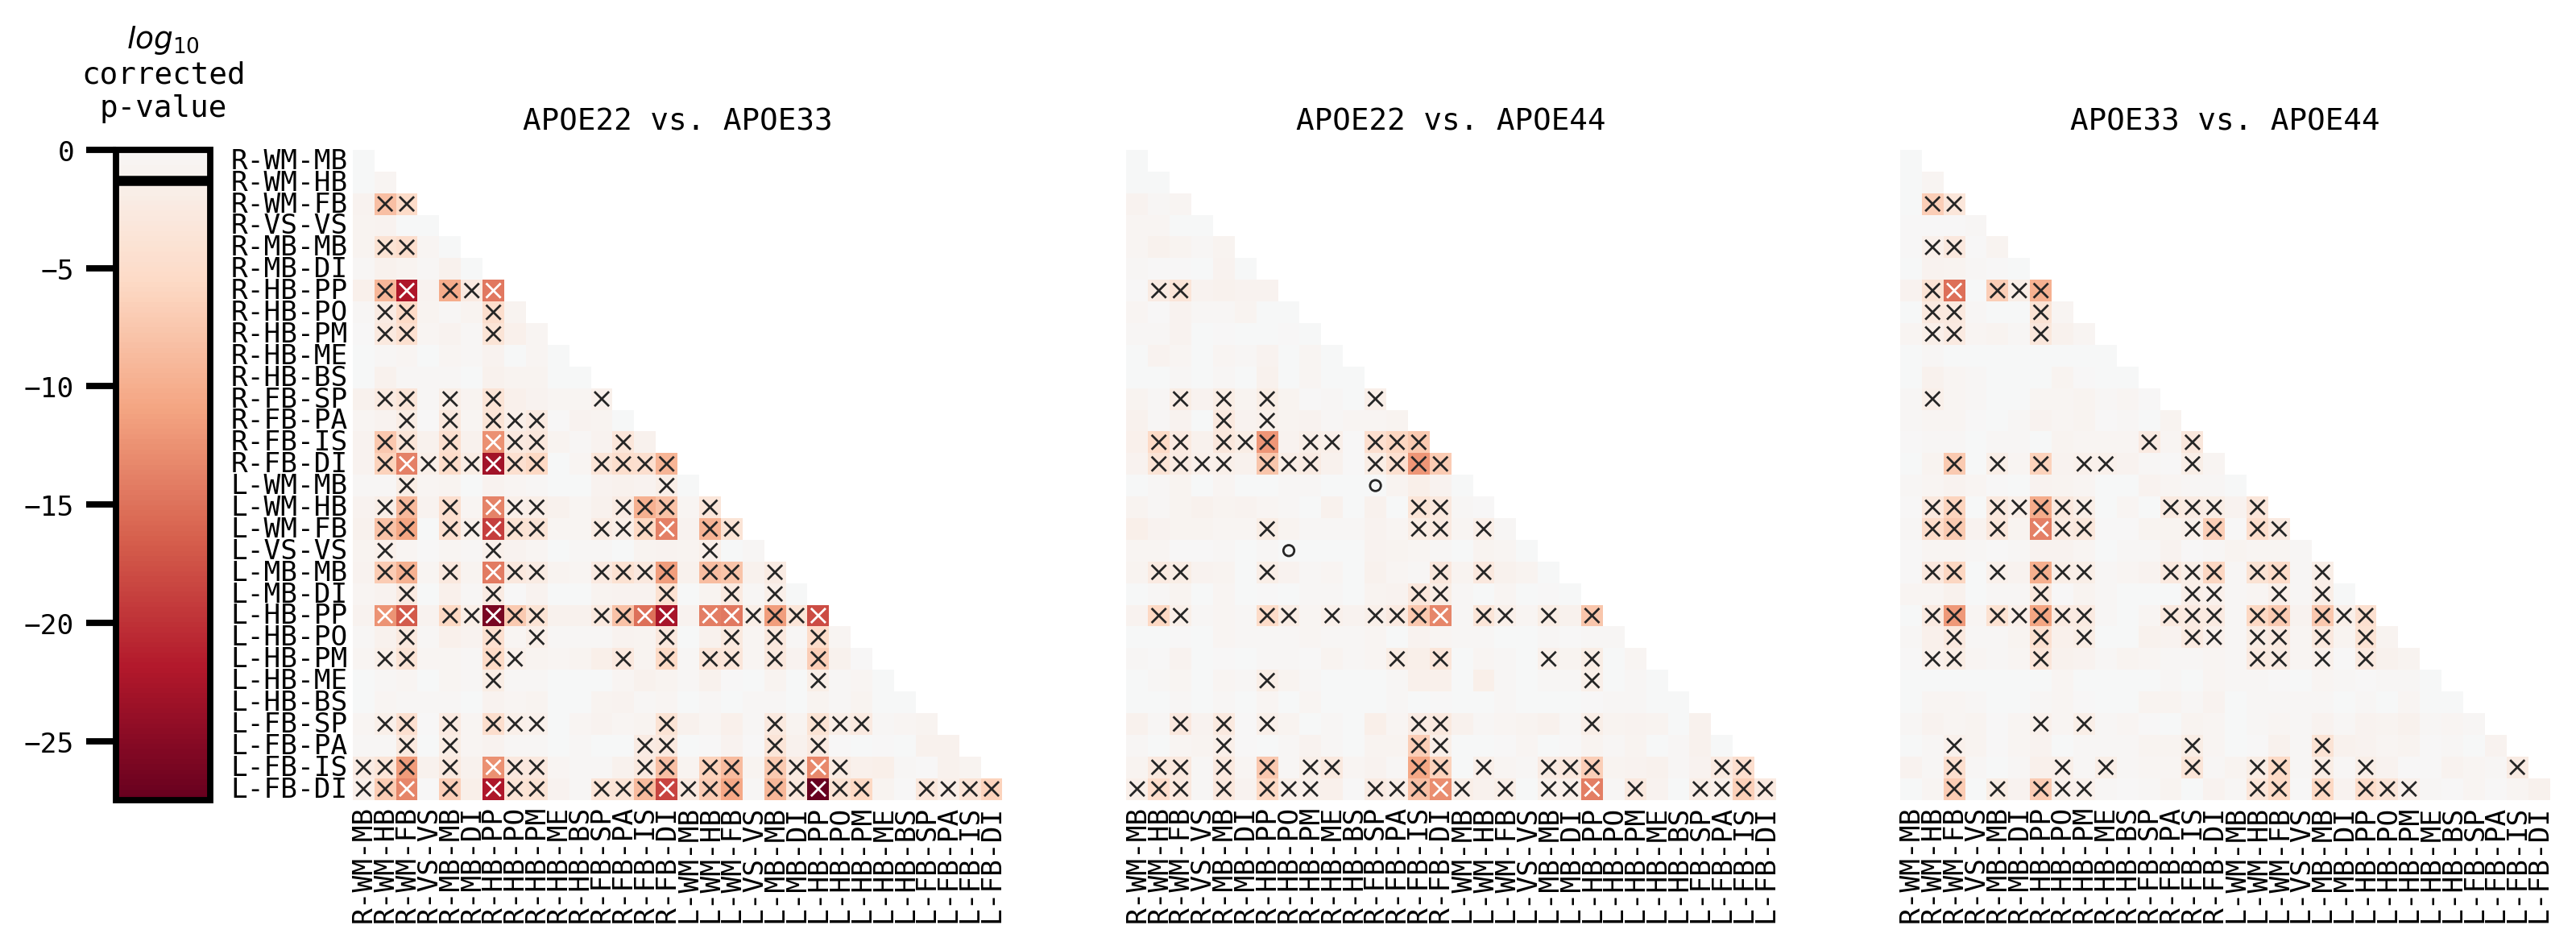

In [20]:
fig, _ = plot_pairwise(volume_pairwise, volume_ksample)
fig.savefig("./figures/apriori_pairwise_volume_binarized.pdf")

In [13]:
fa_pairwise = run_pairwise(
    fa_correlations,
    GENOTYPES,
    vertex_hemisphere_substructures,
    absolute=False,
    test="kruskal",
)

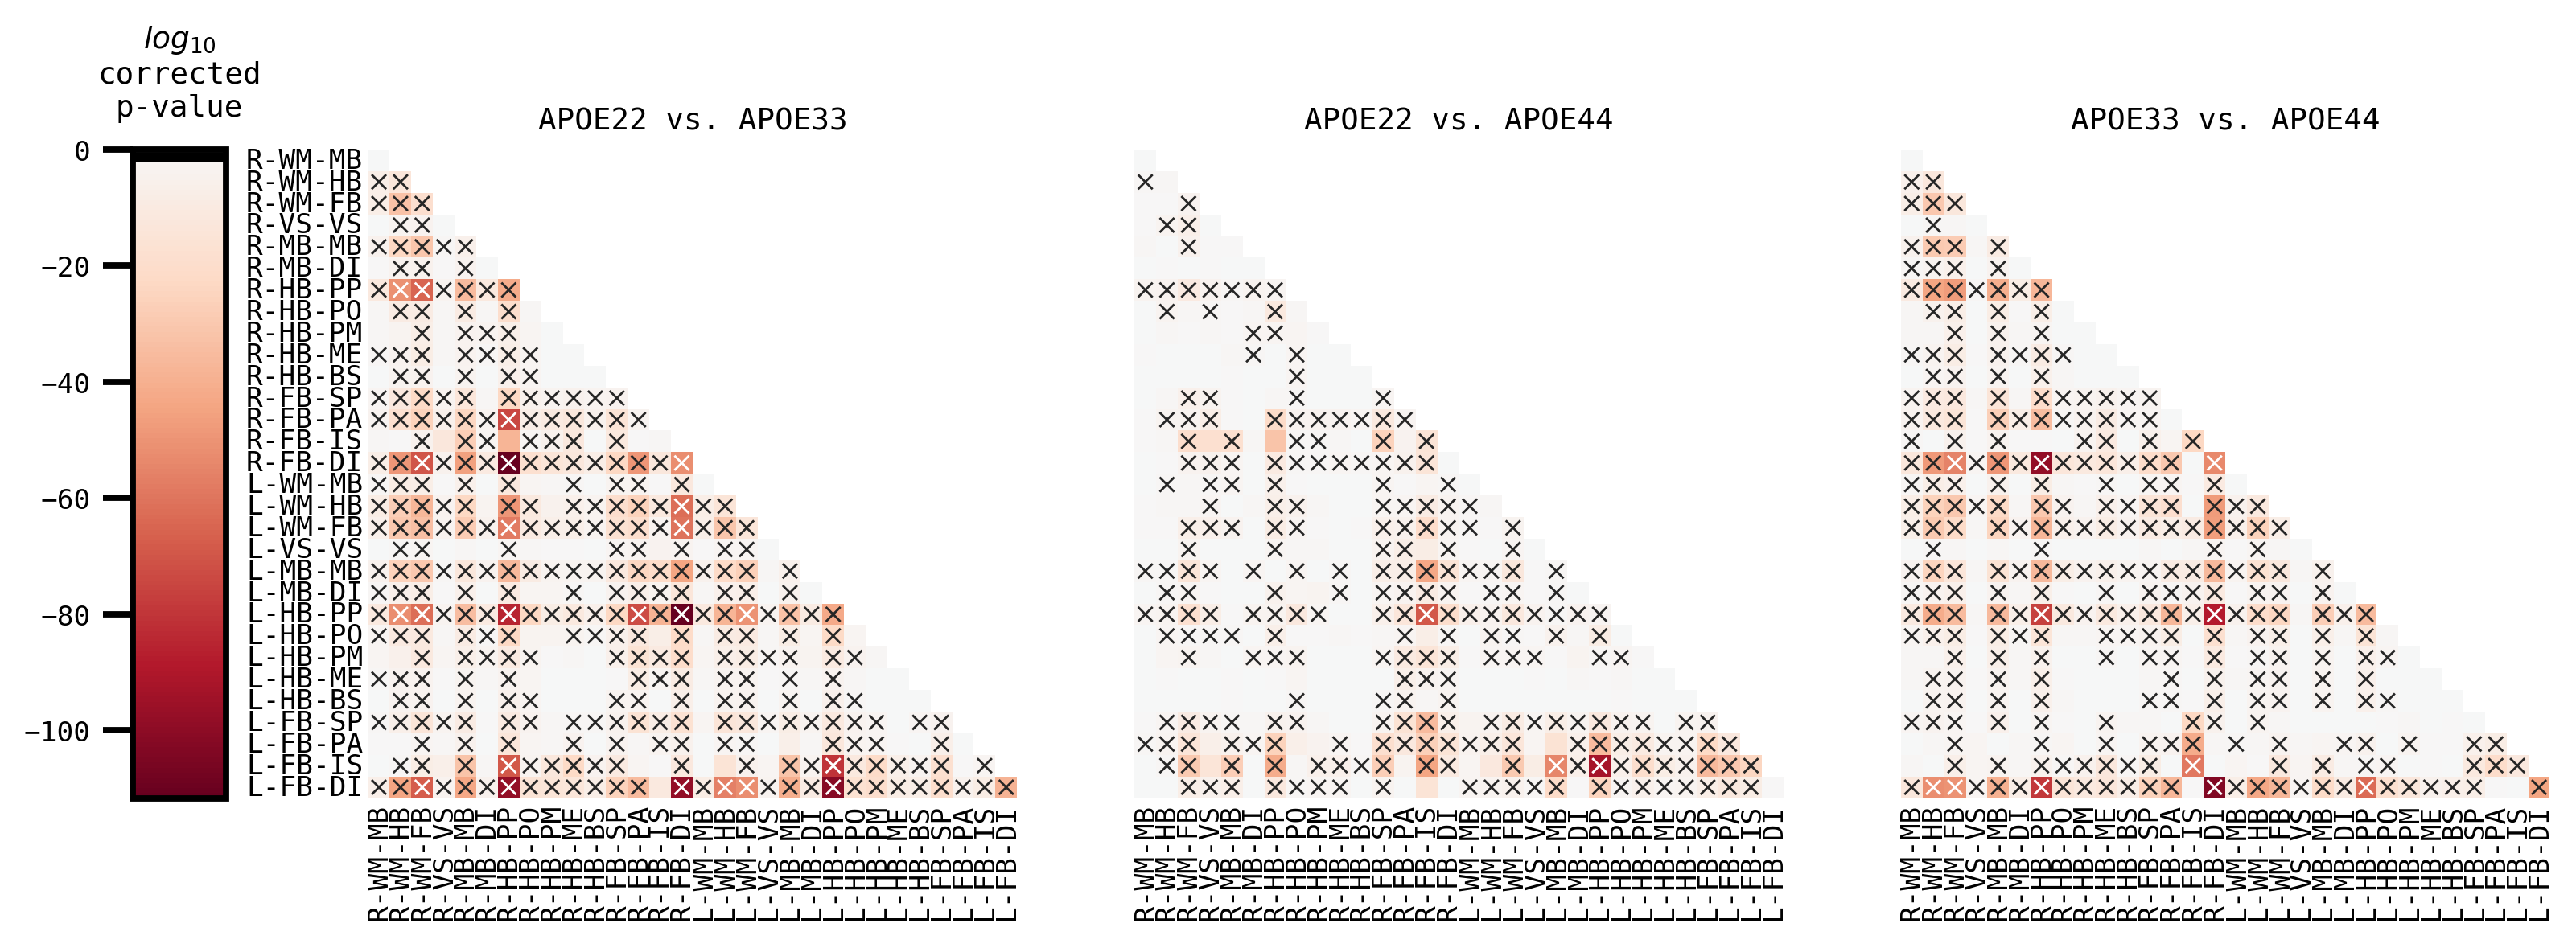

In [14]:
fig, _ = plot_pairwise(fa_pairwise, fa_ksample)

fig.savefig("./figures/apriori_pairwise_fa.pdf")